In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import shutil

from collections import Counter

from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD, IncrementalPCA
from scipy.sparse import csr_matrix, lil_matrix
import scipy
from itertools import chain
import statistics
from sklearn.utils import class_weight
from sklearn.pipeline import make_pipeline
from sklearn import svm, preprocessing
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from numpy import expand_dims

from tensorflow.keras.utils import to_categorical
from tensorflow import concat
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import tensorflow
import os
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras import applications
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt
from keras.applications.vgg19 import preprocess_input
from tensorflow.image import rgb_to_grayscale, grayscale_to_rgb
from tensorflow import tile
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
image_size = 224
input_shape = (image_size, image_size, 3)

2022-11-18 10:12:55.992333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-18 10:12:55.992380: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Importation des données

In [2]:
# importation des données

categories = os.listdir('Dessins_humains/')
categories.remove('.ipynb_checkpoints')
drawings = []
labels = list()

for folder in tqdm(categories):
    tmp_repertory = 'Dessins_humains/' + folder
    #print(folder)
    for img in os.listdir(tmp_repertory):
        if not img.startswith('.'):
            labels.append(folder)
            img = load_img(tmp_repertory + '/' + img, target_size=(224,224,3))
            img = img_to_array(img)
            img = expand_dims(img,axis=0)
            img = preprocess_input(img)
            img = np.array(img)
            img = np.reshape(img, (224,224,3))
            drawings.append(img)

100%|██████████| 12/12 [00:13<00:00,  1.17s/it]


## Afficher une image aléatoire

Dessins_humains/CE1/RAM-BOU-LIBRE.JPG


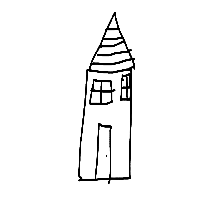

In [ ]:
import random

random_index_category = random.randint(0, len(categories)-1) # -1 car il y a un fichier qui n'est pas une catégorie (le .ipynb)
random_index_drawing = random.randint(0, len(os.listdir('Dessins_humains/' + categories[random_index_category]))-1)
random_drawing_name = os.listdir('Dessins_humains/' + categories[random_index_category])[random_index_drawing]
random_drawing = 'Dessins_humains/' + categories[random_index_category] + '/' + random_drawing_name
random_img = load_img(random_drawing, target_size=(224,224,3))
print(random_drawing)
random_img.show()
random_img = img_to_array(random_img)
random_img = expand_dims(random_img,axis=0)
random_img = preprocess_input(random_img)
random_img = np.array(random_img)
random_img = np.reshape(random_img,(224,224,3))
#plt.imshow(random_img)


## Preprocessing + modèle

##### drawings_new = Array des dessins de la classification en question
##### labels_names = Nom de la classe d'appartenance de chaque dessin (Crèche, PS, etc)
##### labels_final = Nom de la classe utilisée pour la classification (jeune,...)

In [4]:
print(categories)

['Crèche', 'NOV', 'Chimpanzés', 'Méthodo', 'CM1', 'GS', 'PS', 'CE2', 'CE1', 'MS', 'EXP', 'CM2']


### Séparations en catégories à préciser

In [3]:
def preprocess_data(groupes):
    nb_groupes = len(groupes)

    labels_groupes = {}
    index_groupes = {}

    for groupe in list(groupes.keys()): # pour chaque groupe
        labels_groupes[groupe] = [labels[j] for j,x in enumerate(labels) if x in groupes[groupe]]
        index_groupes[groupe] = [j for j,x in enumerate(labels) if x in groupes[groupe]]

    index_length = [len(index_groupes[groupe]) for groupe in groupes]

    for groupe, nb_dessins in zip(list(groupes.keys()), index_length):
        print(f'{groupe} : {nb_dessins}')

    labels_index = sorted(sum(list(index_groupes.values()), []))

    labels_names = []
    drawings_new = []
    for i in tqdm(labels_index):
        labels_names.append(labels[i])
        drawings_new.append(drawings[i])

    labels_final = [''] * len(labels_names)

    for i in range(len(labels_final)):
        for grp_index in range(len(list(groupes.keys()))):
            if labels_names[i] in list(groupes.values())[grp_index]:
                labels_final[i] = list(groupes.keys())[grp_index]
    return drawings_new, labels_final, labels_names

In [57]:
#groupes = {'CrecheGS' : ['Crèche','PS','MS','GS'],'CE1CM2' : ['CE1','CE2','CM1','CM2']}
#drawings_new, labels_final, labels_names = preprocess_data(groupes)

CrecheGS : 149
CE1CM2 : 163


100%|██████████| 312/312 [00:00<00:00, 485574.34it/s]


#### Afficher une image aléatoire

In [6]:
#i = random.randint(0,len(labels_names))
#print('Catégorie du dessinateur : ' + labels_names[i] + ' (' + labels_final[i] + ')')
#plt.imshow(drawings_new[i])

### Toutes les catégories humains (Crèche, PS, MS,..., Nov, Exp) 

In [8]:
categories_humains = ['Crèche','PS','MS','GS','CE1','CE2','CM1','CM2','NOV','EXP']

labels_final = []
drawings_new = []

for i in range(len(labels)):
    if labels[i] in categories_humains:
        drawings_new.append(drawings[i])
        labels_final.append(labels[i])

### 2 groupes d'enfants VS adultes (en décalant à chaque fois chez les enfants)

#### Optimisation bayésienne : meilleurs hyperparamètres pour chaque modèle

In [4]:
def plot_model_history(model_history, accuracy='accuracy', val_accuracy='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[accuracy])+1),model_history.history[accuracy])
    axs[0].plot(range(1,len(model_history.history[val_accuracy])+1),model_history.history[val_accuracy])
    #axs[0].set_xticks(np.arange(1,len(model_history.history[accuracy])+1),len(model_history.history[accuracy])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig('models/' + str(enfants_groupe[0] + enfants_groupe[1]) + '/' + 'curves_' + str(enfants_groupe[0] + enfants_groupe[1]) + '.png')
    #plt.show()

##### /!\ lancer ce code fait tourner les modèles

Trial 50 Complete [00h 05m 02s]
val_loss: 0.686716616153717

Best val_loss So Far: 0.47219422459602356
Total elapsed time: 03h 28m 01s
INFO:tensorflow:Oracle triggered exit
{'batch_size': 16, 'pool_value': 'avg', 'dropout': 0.4, 'num_layers': 1, 'BatchNorm': 1, 'units_0': 288, 'lr': 0.1, 'units_1': 128, 'units_2': 32}
Epoch 1/15
5/5 [==============================] - 26s 5s/step - loss: 0.6838 - accuracy: 0.6074 - val_loss: 2.0896 - val_accuracy: 0.5000
Epoch 2/15
5/5 [==============================] - 25s 5s/step - loss: 0.5787 - accuracy: 0.7407 - val_loss: 2.4729 - val_accuracy: 0.4118
Epoch 3/15
5/5 [==============================] - 25s 5s/step - loss: 0.6907 - accuracy: 0.6444 - val_loss: 0.9560 - val_accuracy: 0.5882
Epoch 4/15
5/5 [==============================] - 25s 5s/step - loss: 0.4928 - accuracy: 0.7778 - val_loss: 1.1496 - val_accuracy: 0.5294
Epoch 5/15
5/5 [==============================] - 25s 5s/step - loss: 0.4724 - accuracy: 0.7556 - val_loss: 0.7934 - val_accurac

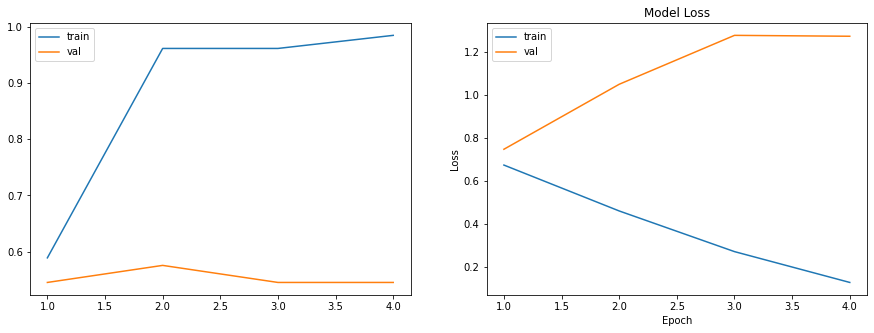

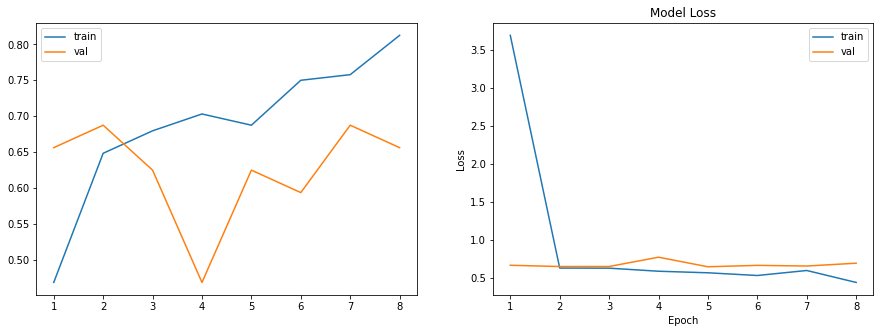

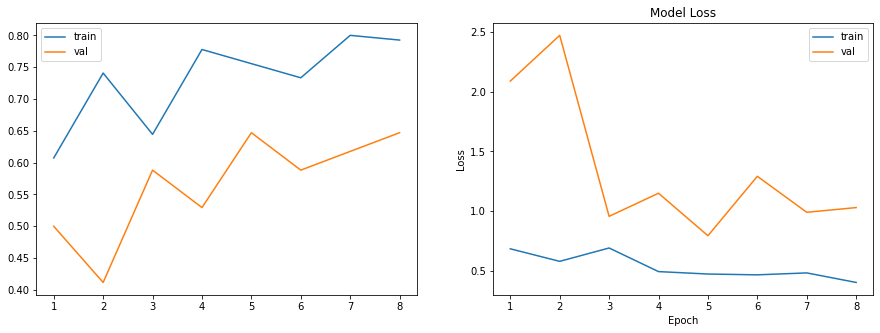

In [5]:
enfants = ['Crèche','PS','MS','GS','CE1','CE2','CM1','CM2']
adultes = ['NOV','EXP']

data_augmentation = tf.keras.Sequential(
    [       tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
    ]
)

scores = list()



for i in range(len(enfants)-1):
    enfants_groupe = enfants[i:i+2]
    print('********************Loop running for ' + enfants_groupe[0] + enfants_groupe[1] + ' ********************')
    
    # si le code n'a pas encore tourné complètement pour ces catégories :
    if 'model_' + str(enfants_groupe[0] + enfants_groupe[1]) + '.h5' not in os.listdir('models/' + enfants_groupe[0] + enfants_groupe[1]):
        # mise en forme des données :
        groupes = {enfants_groupe[0]+enfants_groupe[1]:enfants_groupe, adultes[0]+adultes[1]:adultes}
        drawings_new, labels_final, labels_names = preprocess_data(groupes)
        drawings_new = np.reshape(drawings_new,(len(drawings_new),224,224,3))
        for label_idx in range(len(labels_final)):
            if labels_final[label_idx] != 'NOVEXP':
                labels_final[label_idx] = '0' + labels_final[label_idx]
            else:
                labels_final[label_idx] = '1' + labels_final[label_idx]
        le = LabelEncoder()
        labels_final = le.fit_transform(labels_final)
        X_train, X_val, Y_train, Y_val = train_test_split(drawings_new,labels_final, test_size = 0.2, random_state = 42)
        
        # optimisation bayésienne
        class MyHyperModel(kt.HyperModel):
            def model_builder(self,hp):
                '''
            Args:
            hp - Keras tuner object
                '''
                batch_size=hp.Choice("batch_size", [16, 32, 64])
                # 3 possibilités pour pool à partir de VGG : avg, max, None
                pool_value = hp.Choice('pool_value',values=['avg','max','None'])
                if pool_value == 'None': # si None, il faut le type None
                    pool_value = None

                inputs = tf.keras.Input(shape=(224,224,3))
                inputs = data_augmentation(inputs) 
                x = keras.applications.vgg19.VGG19(
                input_tensor=inputs, 
                include_top=False,
                pooling=pool_value,
                weights='imagenet'
                )

                x.trainable = False
                x = Flatten()(x.output)
                hp_dropout = hp.Float('dropout', min_value=0, max_value=0.4, step=0.1)
                x = Dropout(hp_dropout)(x)
                # Tune the number of layers
                nb_layers = hp.Int("num_layers", 1, 3)
                BatchNorm = hp.Choice('BatchNorm',[True,False])
                for num_layer in range(nb_layers):
                    # Tune the number of neurons in each layer
                    hp_units = hp.Int(f'units_{num_layer}', min_value=32, max_value=512, step=32)  
                    x = Dense(hp_units)(x)
                    if num_layer==0:
                        with hp.conditional_scope("BatchNorm", [True]):
                            if BatchNorm == True:
                                x = BatchNormalization()(x)
                    x = Activation('relu')(x)
                outputs = Dense(1, activation='sigmoid')(x)
                model = Model(inputs,outputs)
                learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
                model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.SGD(learning_rate),
                      metrics=['accuracy'])
                return model

            def fit(self, hp, model, *args, **kwargs):
                return model.fit(
                    *args,
                    batch_size=self.batch_size,
                    **kwargs,
                )

        # Instantiate the tuner
        tuner = kt.tuners.BayesianOptimization(
        MyHyperModel().model_builder,
        objective = 'val_loss',
        max_trials = 50, ###########################
        directory = 'models',
    #        overwrite = True,
        project_name = str(enfants_groupe[0] + enfants_groupe[1]))

        tuner.search_space_summary()
        early_stop_tuner = tf.keras.callbacks.EarlyStopping(
                                monitor = 'val_loss',
                                patience = 3, ##############################################
                                restore_best_weights = True)
        
        
        class_weights = class_weight.compute_class_weight(
                                class_weight = "balanced",
                                classes = np.unique(Y_train),
                                y = Y_train                                                    
                            )
        class_weight_dict = dict(enumerate(class_weights))
        tuner.search(X_train, Y_train, epochs=15, ##########################
                     validation_data=(X_val, Y_val), verbose=2, callbacks = [early_stop_tuner],
                     class_weight = class_weight_dict) 
        # Get the top 2 hyperparameters.
        #best_hps = tuner.get_best_hyperparameters(5)
        best_hps = tuner.get_best_hyperparameters()[0]
        print(best_hps.values)
        # Build the model with the best hp.
        best_model = MyHyperModel().model_builder(best_hps)
        early_stop = tf.keras.callbacks.EarlyStopping(
                                monitor = 'val_loss',
                                patience = 3, ##############################################
                                restore_best_weights = True)

        history = best_model.fit(X_train,Y_train, epochs=15, validation_data=(X_val,Y_val), ############################
                        callbacks = [early_stop], class_weight = class_weight_dict)
        plot_model_history(history)

        epoch_val_loss_min = np.argmin(history.history['val_loss'])
        val_max = history.history['val_accuracy'][epoch_val_loss_min]
        with open('models/' + str(enfants_groupe[0] + enfants_groupe[1]) + '/' + 'models_scores.txt', 'a') as f:
            f.writelines('accuracy : ' + str(val_max) + '\n' + str(best_hps.values))
        scores.append(val_max)
        best_model.save('models/' + str(enfants_groupe[0] + enfants_groupe[1]) + '/' + 'model_' + str(enfants_groupe[0] + enfants_groupe[1]) + '.h5')
    for folder in os.listdir('models/' + enfants_groupe[0] + enfants_groupe[1]):
        if 'trial' in folder:
            shutil.rmtree('models/' + enfants_groupe[0]+ enfants_groupe[1] + '/' + folder)

In [6]:
enfants = ['Crèche','PS','MS','GS','CE1','CE2','CM1','CM2']

categories_couple = []
for i in range(len(enfants)-1):
    enfants_groupe = enfants[i:i+2]
    categories_couple.append(enfants_groupe[0] + enfants_groupe[1])

In [7]:
scores = []
for categorie_couple in categories_couple:
    with open('models/' + categorie_couple +'/models_scores.txt') as f:
        lines = f.readlines()
    scores.append(float(lines[0].split(':')[1]))
    

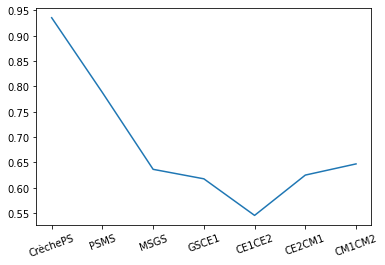

In [8]:
plt.xticks(list(range(len(enfants)-1)), categories_couple,
       rotation=20)
plt.plot(scores)